In [21]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix,classification_report


In [22]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhardha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
dataset = pd.read_csv('reviews.txt',sep = '\t', names =['Reviews','Comments'])

In [24]:
dataset

,Reviews,Comments
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...
...,...,...
6913,0,Brokeback Mountain was boring.
6914,0,So Brokeback Mountain was really depressing.
6915,0,"As I sit here, watching the MTV Movie Awards, ..."
6916,0,Ok brokeback mountain is such a horrible movie.


In [25]:
Y = dataset['Reviews']
X = dataset.drop(['Reviews'], axis = 1)

In [26]:
stopset = set(stopwords.words('english'))

In [27]:
vectorizer = TfidfVectorizer(use_idf = True,lowercase = True, strip_accents='ascii',stop_words=stopset)

In [28]:
X = vectorizer.fit_transform(dataset.Comments)
y = dataset.Reviews
pickle.dump(vectorizer, open('tranform.pkl', 'wb'))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 1) Naive Bayes

In [30]:
clf = naive_bayes.MultinomialNB()
clf.fit(X_train,y_train)


MultinomialNB()

In [31]:
pred_naive = clf.predict(X_test)

In [33]:
accuracy_score(y_test,clf.predict(X_test))*100

97.47109826589595

In [34]:
clf = naive_bayes.MultinomialNB()
clf.fit(X,y)

MultinomialNB()

In [35]:
accuracy_score(y_test,clf.predict(X_test))*100

98.77167630057804

In [36]:
#filename = 'nlp_model.pkl'
#pickle.dump(clf, open(filename, 'wb'))

# 2) KNN

In [37]:
tuned_parameters_knn = {'n_neighbors' : [i for i in range(3,13,2)]}

In [38]:
KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X,y)

KNeighborsClassifier()

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
knn_model = KNeighborsClassifier()
knn = GridSearchCV(knn_model, tuned_parameters_knn, cv=10, scoring='accuracy')
knn.fit(X_train, y_train)
knn.best_score_*100

98.3196349416703

In [41]:
knn.best_params_

{'n_neighbors': 5}

In [42]:
pred_knn = knn.predict(X_test)

In [43]:
filename = 'nlp_knn_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [44]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# evaluate model
knn_auc = cross_val_score(knn, X_train, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
knn_accuracy = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [48]:

pd.DataFrame([[accuracy_score(y_test, pred_knn)*100,  '-'],[np.mean(knn_accuracy)*100, np.mean(knn_auc)*100]], columns = ['Accuracy', 'AUC'], index = ['Prediction', 'K-fold'])


,Accuracy,AUC
Prediction,97.687861,-
K-fold,98.283469,99.497832


Text(0, 0.5, 'AUC')

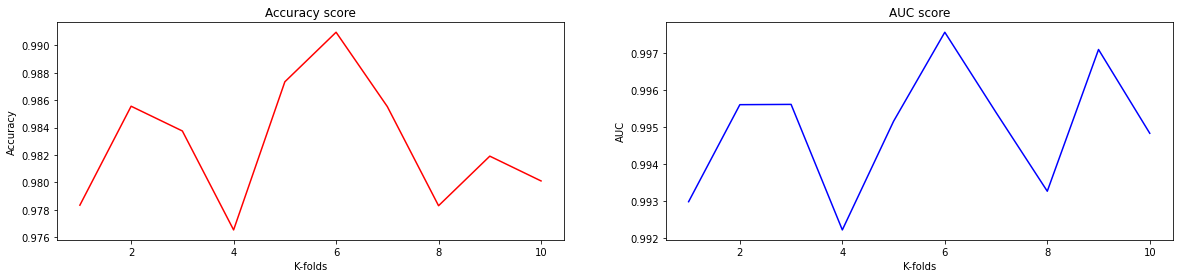

In [49]:
degree = [i for i in range(1,11)]

f, (ax0, ax1)= plt.subplots(1, 2, figsize=(20,4))
ax0.plot(degree,knn_accuracy,color='r')
ax0.set_title('Accuracy score')
ax0.set_xlabel('K-folds')
ax0.set_ylabel('Accuracy')

ax1.plot(degree,knn_auc,color='b')
ax1.set_title('AUC score')
ax1.set_xlabel('K-folds')
ax1.set_ylabel('AUC')

# 3) Logistic Regression

In [50]:
tuned_parameters_log = {'penalty' : ['l2', 'none'], 'C' : [i for i in range(1,80,10)], 'class_weight' : [None,'balanced'], 
                        'max_iter' : [i for i in range(400,1000,100)]}

In [51]:
log_reg = LogisticRegression(solver = 'lbfgs', random_state = 0, C= 1, class_weight= None, max_iter = 400, penalty = 'l2')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=400, random_state=0)

In [52]:
pred_log = log_reg.predict(X_test)

In [53]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# evaluate model
log_auc = cross_val_score(log_reg, X_train, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
log_accuracy = cross_val_score(log_reg, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [54]:
pd.DataFrame([[accuracy_score(y_test, pred_log)*100,  '-'],[np.mean(log_accuracy)*100, np.mean(log_auc)*100]], columns = ['Accuracy', 'AUC'], index = ['Prediction', 'K-fold'])

,Accuracy,AUC
Prediction,98.554913,-
K-fold,99.259046,99.97932


Text(0, 0.5, 'AUC')

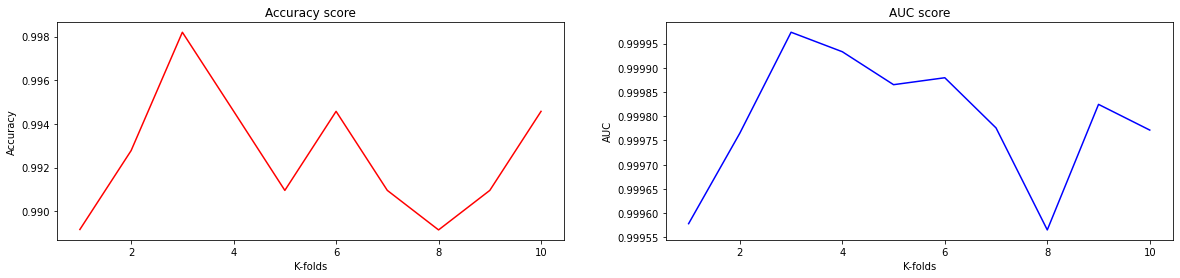

In [55]:
degree = [i for i in range(1,11)]

f, (ax0, ax1)= plt.subplots(1, 2, figsize=(20,4))
ax0.plot(degree,log_accuracy,color='r')
ax0.set_title('Accuracy score')
ax0.set_xlabel('K-folds')
ax0.set_ylabel('Accuracy')

ax1.plot(degree,log_auc,color='b')
ax1.set_title('AUC score')
ax1.set_xlabel('K-folds')
ax1.set_ylabel('AUC')

# 4) SVM

In [56]:
tuned_parameters_svm = {'C': (np.arange(4,6,0.2)) , 'kernel': ['linear', 'rbf', 'poly'],
                    'gamma': [0.01,0.1,1,10], 'degree': [2,3,4]}

In [57]:
svm = SVC(probability=True, random_state = 0, C = 5, degree = 2, gamma = 0.01, kernel = 'linear')
svm.fit(X_train, y_train)

SVC(C=5, degree=2, gamma=0.01, kernel='linear', probability=True,
    random_state=0)

In [58]:
pred_svm = svm.predict(X_test)

In [59]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# evaluate model
svm_auc = cross_val_score(svm, X_train, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
svm_accuracy = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [60]:
pd.DataFrame([[accuracy_score(y_test, pred_svm)*100, '-'],[np.mean(svm_accuracy)*100,np.mean(svm_auc)*100]], columns = ['Accuracy', 'AUC'], index = ['Prediction', 'K-fold'])

,Accuracy,AUC
Prediction,98.988439,-
K-fold,99.403777,99.98696


Text(0, 0.5, 'AUC')

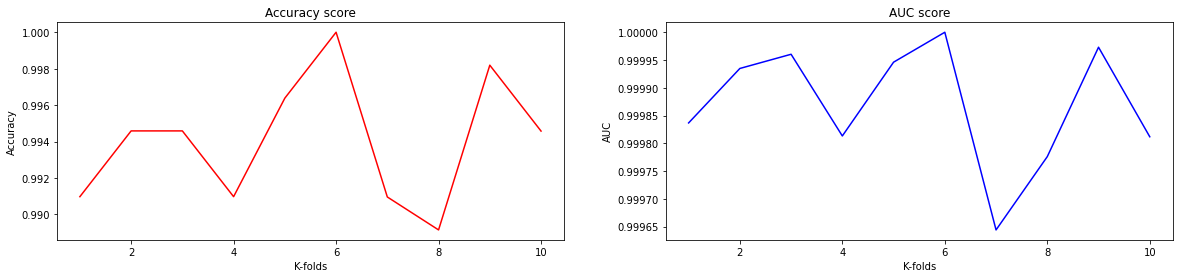

In [61]:
degree = [i for i in range(1,11)]

f, (ax0, ax1)= plt.subplots(1, 2, figsize=(20,4))
ax0.plot(degree,svm_accuracy,color='r')
ax0.set_title('Accuracy score')
ax0.set_xlabel('K-folds')
ax0.set_ylabel('Accuracy')

ax1.plot(degree,svm_auc,color='b')
ax1.set_title('AUC score')
ax1.set_xlabel('K-folds')
ax1.set_ylabel('AUC')

# 5) Decision Tree

In [62]:
tuned_parameters_dtc = {'criterion' : ['gini', 'entropy'], 'max_depth' : list(range(3,7)), 'min_samples_split' : list(range(3,7)), 
                    'min_samples_leaf' : list(range(3,7)), 'max_leaf_nodes' : list(range(3,12))}

In [63]:
dtc = DecisionTreeClassifier(random_state = 0, criterion = 'gini', max_depth = 3, max_leaf_nodes = 4, min_samples_leaf = 3, min_samples_split = 3)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, min_samples_leaf=3,
                       min_samples_split=3, random_state=0)

In [64]:
pred_dtc = dtc.predict(X_test)

In [65]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# evaluate model
dtc_auc = cross_val_score(dtc, X_train, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
dtc_accuracy = cross_val_score(dtc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [67]:
pd.DataFrame([[accuracy_score(y_test, pred_dtc)*100, '-'],[np.mean(dtc_accuracy)*100, np.mean(dtc_auc)*100]], columns = ['Accuracy', 'AUC'], index = ['Prediction', 'K-fold'])

,Accuracy,AUC
Prediction,88.800578,-
K-fold,89.158153,90.770275


Text(0, 0.5, 'AUC')

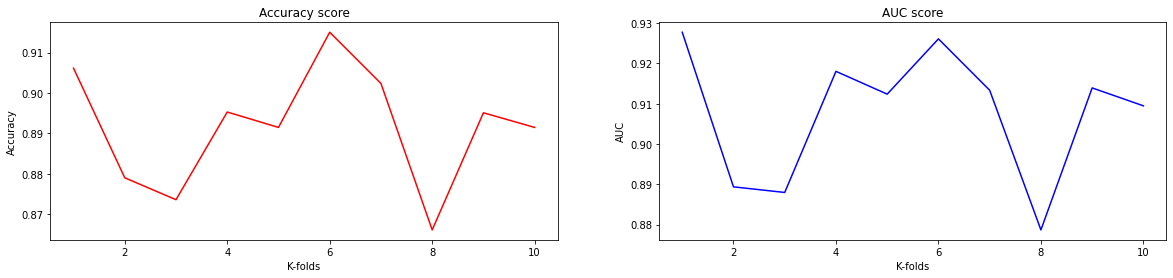

In [68]:
degree = [i for i in range(1,11)]

f, (ax0, ax1)= plt.subplots(1, 2, figsize=(20,4))
ax0.plot(degree,dtc_accuracy,color='r')
ax0.set_title('Accuracy score')
ax0.set_xlabel('K-folds')
ax0.set_ylabel('Accuracy')

ax1.plot(degree,dtc_auc,color='b')
ax1.set_title('AUC score')
ax1.set_xlabel('K-folds')
ax1.set_ylabel('AUC')

# 6) Random Forest

In [69]:
tuned_parameters_rfc = {'n_estimators' : [i for i in range(100,160,10)], 'criterion' : ['gini', 'entropy'], 
                        'max_depth' : list(range(15,40,5)), 'min_samples_split' : list(range(2,5)), 
                        'min_samples_leaf' : list(range(1,5)), 'max_leaf_nodes' : list(range(10,210,50)),'max_features' : ['auto', 'log2', None]}

In [70]:
rfc = RandomForestClassifier(random_state = 0, n_estimators = 150)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

In [71]:
pred_rfc = rfc.predict(X_test)

In [72]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# evaluate model
rfc_auc = cross_val_score(rfc, X_train, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
rfc_accuracy = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [73]:
pd.DataFrame([[accuracy_score(y_test, pred_rfc)*100, '-'],[np.mean(rfc_accuracy)*100, np.mean(rfc_auc)*100]], columns = ['Accuracy', 'AUC'], index = ['Prediction', 'K-fold'])

,Accuracy,AUC
Prediction,98.916185,-
K-fold,99.295278,99.985282


Text(0, 0.5, 'AUC')

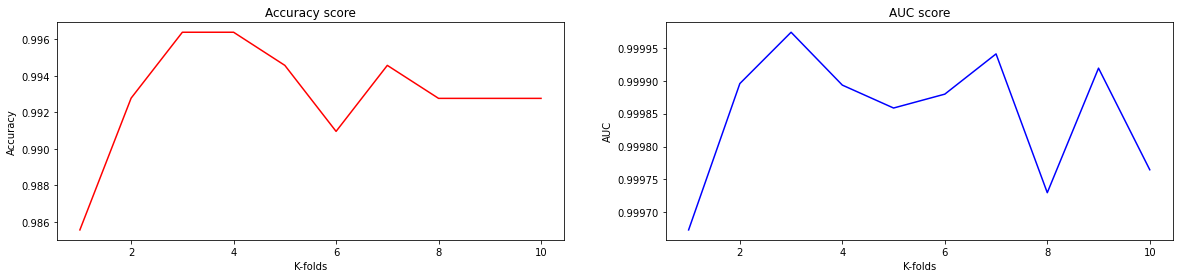

In [74]:
degree = [i for i in range(1,11)]

f, (ax0, ax1)= plt.subplots(1, 2, figsize=(20,4))
ax0.plot(degree,rfc_accuracy,color='r')
ax0.set_title('Accuracy score')
ax0.set_xlabel('K-folds')
ax0.set_ylabel('Accuracy')

ax1.plot(degree,rfc_auc,color='b')
ax1.set_title('AUC score')
ax1.set_xlabel('K-folds')
ax1.set_ylabel('AUC')

# Metrix

In [75]:
model_pred = {'KNN' : pred_knn, 'Logistic Regression' : pred_log, 'SVM' : pred_svm, 'Decision Tree Classifier' : pred_dtc, 'Random Forest Classifier' : pred_rfc}

Confusion Metrix

In [76]:
for v,k in model_pred.items():
    print(f'{v} :\n{confusion_matrix(y_test, model_pred[v])}\n\n\n')

KNN :
[[554  26]
 [  6 798]]



Logistic Regression :
[[566  14]
 [  6 798]]



SVM :
[[571   9]
 [  5 799]]



Decision Tree Classifier :
[[564  16]
 [139 665]]



Random Forest Classifier :
[[571   9]
 [  6 798]]





Classification Report

In [77]:
for v,k in model_pred.items():
    print(f'{v} :\n{classification_report(y_test, model_pred[v])}\n\n\n')

KNN :
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       580
           1       0.97      0.99      0.98       804

    accuracy                           0.98      1384
   macro avg       0.98      0.97      0.98      1384
weighted avg       0.98      0.98      0.98      1384




Logistic Regression :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       580
           1       0.98      0.99      0.99       804

    accuracy                           0.99      1384
   macro avg       0.99      0.98      0.99      1384
weighted avg       0.99      0.99      0.99      1384




SVM :
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       580
           1       0.99      0.99      0.99       804

    accuracy                           0.99      1384
   macro avg       0.99      0.99      0.99      1384
weighted avg       0.99      0.99 

In [106]:
accuracy = [ 
            [accuracy_score(y_test, pred_knn)*100, np.mean(knn_accuracy)*100, np.mean(knn_auc)*100], 
            [accuracy_score(y_test, pred_log)*100, np.mean(log_accuracy)*100, np.mean(log_auc)*100], 
            [accuracy_score(y_test, pred_svm)*100, np.mean(svm_accuracy)*100, np.mean(svm_auc)*100], 
            [accuracy_score(y_test, pred_dtc)*100, np.mean(dtc_accuracy)*100, np.mean(dtc_auc)*100], 
            [accuracy_score(y_test, pred_rfc)*100, np.mean(rfc_accuracy)*100, np.mean(rfc_auc)*100]]

pd.DataFrame(accuracy, columns = ['Prediction Accuracy', 'K-Fold Accuracy', 'AUC score'], 
             index = [ 'K-Nearest Neighbour', 'Logistic Regression', 'Support Vector Machine', 'Decision Tree Classifier', 'Random Forest Classifier'])

,Prediction Accuracy,K-Fold Accuracy,AUC score
K-Nearest Neighbour,97.687861,98.283469,99.497832
Logistic Regression,98.554913,99.259046,99.979320
Support Vector Machine,98.988439,99.403777,99.986960
Decision Tree Classifier,88.800578,89.158153,90.770275
Random Forest Classifier,98.916185,99.295278,99.985282


# Implementing Boosting Algorithms

In [79]:
from sklearn.ensemble import AdaBoostClassifier

ADA Boosting

In [80]:
def adaboostclassifier(est, X_train, y_train, X_test, y_test):
    ada = AdaBoostClassifier(base_estimator = est, n_estimators=50, learning_rate=1)
    adaboost = ada.fit(X_train, y_train)
    Y_pred_ada = adaboost.predict(X_test)
    return accuracy_score(y_test, Y_pred_ada)

Gradient Boosting

In [81]:
def gradboostclassifier(est, X_train, y_train, X_test, y_test):
    grb = GradientBoostingClassifier(init = est, n_estimators=50, learning_rate=1)
    gradboost = grb.fit(X_train, y_train)
    Y_pred_grb = gradboost.predict(X_test)
    return accuracy_score(y_test, Y_pred_grb)

# Comparision between models by implementing Boosting Algorithms

In [82]:
base_est = {'Logistic' : log_reg, 'SVM' : svm, 'Decision Tree' : dtc, 'Random Forest' : rfc}

In [89]:
from sklearn.ensemble import GradientBoostingClassifier
boost_acc = []
for v,k in base_est.items():
    ada = adaboostclassifier(base_est[v], X_train, y_train, X_test, y_test)
    grad = gradboostclassifier(base_est[v], X_train, y_train, X_test, y_test)
    acc = [ada*100, grad*100]
    boost_acc.append(acc)

In [90]:
pd.DataFrame(boost_acc, columns = ['AdaBoost', 'Gradient Boosting'], index = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree Classifier', 'Random Forest Classifier'])


,AdaBoost,Gradient Boosting
Logistic Regression,95.881503,98.699422
Support Vector Machine,98.771676,98.988439
Decision Tree Classifier,98.916185,98.193642
Random Forest Classifier,98.771676,99.349711


# Voting Classifier

In [91]:
from sklearn.ensemble import VotingClassifier

In [92]:
estimators = []
estimators.append(('Logistic', log_reg))
estimators.append(('SVM', svm))
estimators.append(('Decision Tree', dtc))
estimators.append(('Random Forest', rfc))

In [93]:
voting = VotingClassifier(estimators=estimators)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic',
                              LogisticRegression(C=1, max_iter=400,
                                                 random_state=0)),
                             ('SVM',
                              SVC(C=5, degree=2, gamma=0.01, kernel='linear',
                                  probability=True, random_state=0)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_leaf_nodes=4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     random_state=0)),
                             ('Random Forest',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=0))])

In [94]:
Y_pred_vote = voting.predict(X_test)
print(f'Accuracy with Voting Classifier: {accuracy_score(y_test, Y_pred_vote)}')

Accuracy with Voting Classifier: 0.9877167630057804


In [95]:
vote = {
    'Train':{},
    'Test':{accuracy_score(y_test, voting.predict(X_test))}
}

In [96]:
scores = {
    'Train' : {
               'KNN': accuracy_score(y_train, knn.predict(X_train)),
               'Logistic':accuracy_score(y_train, log_reg.predict(X_train)),
               'SVM':accuracy_score(y_train, svm.predict(X_train)),
               'Decision Tree':accuracy_score(y_train, dtc.predict(X_train)),
               'Random Forest':accuracy_score(y_train, rfc.predict(X_train)),
               'Voting Classifier':accuracy_score(y_train, voting.predict(X_train))
              },
    'Test' : {
               'KNN': accuracy_score(y_test, pred_knn),
               'Logistic':accuracy_score(y_test, pred_log),
               'SVM':accuracy_score(y_test, pred_svm),
               'Decision Tree':accuracy_score(y_test, pred_dtc),
               'Random Forest':accuracy_score(y_test, pred_rfc),
              'Voting Classifier':accuracy_score(y_test, voting.predict(X_test))
             }
}

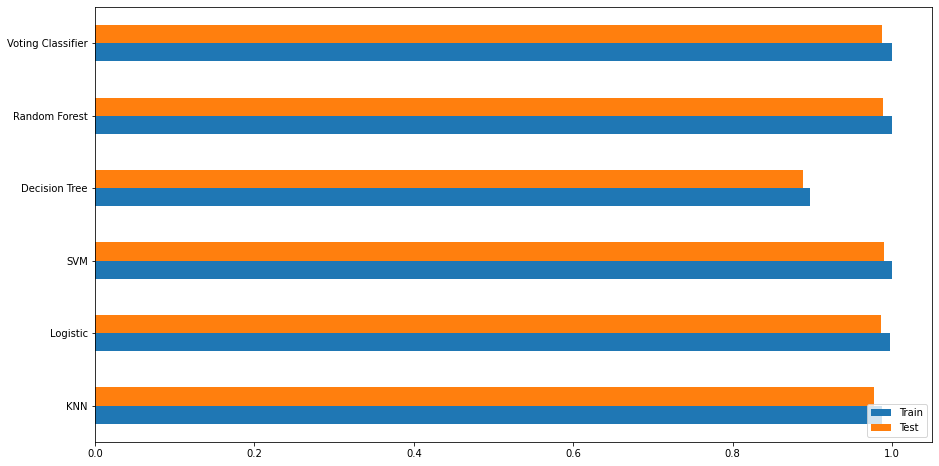

In [97]:
scores_data = pd.DataFrame(scores)

scores_data.plot(kind='barh', figsize=(15,8))

plt.legend(loc = 'lower right')

In [108]:
filename = 'nlp_model.pkl'
pickle.dump(pred_rfc, open(filename, 'wb'))